Getting the data through the API and creating dataframes for each for data analysis

In [1]:
import requests
import json

# Dictionary structure for easy data access and storage
# output = {
#     "contacts": {
#         "url": "https://hackathon.syftanalytics.com/api/contacts",
#         "data": None,
#     },
#     "items": {
#         "url": "https://hackathon.syftanalytics.com/api/item",
#         "data": None,
#     ...
#     }}

# Creating a function to generate the above dictionary structure.
from urllib.parse import urlparse, urlsplit
def generate_output_dict(url_list):
    output = {}
    for url in url_list:
        parsed_url = urlparse(url)
        key = parsed_url.path.split('/')[-1]
        output[key] = {
            "url": url,
            "data": None
        }
    return output

url_list = [
    "https://hackathon.syftanalytics.com/api/contacts",
    "https://hackathon.syftanalytics.com/api/item",
    "https://hackathon.syftanalytics.com/api/invoice",
    "https://hackathon.syftanalytics.com/api/payment"
]

output = generate_output_dict(url_list)
headers = {'x-api-key': 'e6506999-8738-4866-a13f-2a2cfb14ba99'}

# Iterating through the URLs and getting the data back
for key in output:
    response = requests.get(output[key]['url'], headers=headers)
    
    # Check if the request was successful
    if response.status_code == 200:
        json_data = response.json()["data"]
        # Add the data of each URL to the output dictionary
        output[key]['data'] = json_data
        #print(f"Data for {key}:")
        #print(json.dumps(json_data, indent=4))
        
    else:
        print(f"Failed to get data for {key}: {response.content}")

In [2]:
import pandas as pd
pd.set_option('display.max_rows', None)

In [3]:
list(output.keys())

['contacts', 'item', 'invoice', 'payment']

In [4]:
#Creating dataframes for each of the elements we want to analyse
contacts_df = pd.DataFrame(output["contacts"]["data"]) 
item_df = pd.DataFrame(output["item"]["data"])
invoice_df = pd.DataFrame(output["invoice"]["data"])
payment_df = pd.DataFrame(output["payment"]["data"])

In [5]:
import os
#saving each df in a csv file for easier read in
def save_dfs_to_csv(df_list, df_names):
    if not os.path.exists('./Data'):
        os.makedirs('./Data')

    # Loop through each DataFrame
    for df, name in zip(df_list, df_names):
        # Create the path for the CSV
        csv_path = f"./Data/{name}.csv"
        df.to_csv(csv_path)
        print(f"Saved {name}.csv in ./Data/")
        
save_dfs_to_csv([contacts_df, item_df, invoice_df, payment_df],["contacts", "items", "invoices", "payments"])

Saved contacts.csv in ./Data/
Saved items.csv in ./Data/
Saved invoices.csv in ./Data/
Saved payments.csv in ./Data/


---

# Exploratory Data Analysis

### Payments

In [6]:
payment_df.head()

,id,date,contact_id,total,exchange_rate,is_income
0,24f4cfe3-c0af-4718-8426-5fbecd37d8ce,2021-01-06T00:00:00.000Z,8e81fbc4-4f33-4ae9-bf5e-a2415372e77b,174.80,1.000,True
1,d197e443-84ff-44ef-89d3-50fdf40c10c1,2021-02-06T00:00:00.000Z,8e81fbc4-4f33-4ae9-bf5e-a2415372e77b,174.80,1.000,True
2,eaac2b16-1885-47a2-86d5-dd5391f5a879,2021-03-06T00:00:00.000Z,8e81fbc4-4f33-4ae9-bf5e-a2415372e77b,174.80,1.000,True
3,129d0813-b934-401e-a2d5-8a03f65c8143,2021-04-06T00:00:00.000Z,8e81fbc4-4f33-4ae9-bf5e-a2415372e77b,174.80,1.000,True
4,faf9d697-e9af-46d7-8ed9-d6924cedb643,2021-04-09T00:00:00.000Z,a9797cb2-4805-4528-bbcb-fdb94368bee6,269.39,1.921,True


Checking the distribution of income and non-income transactions

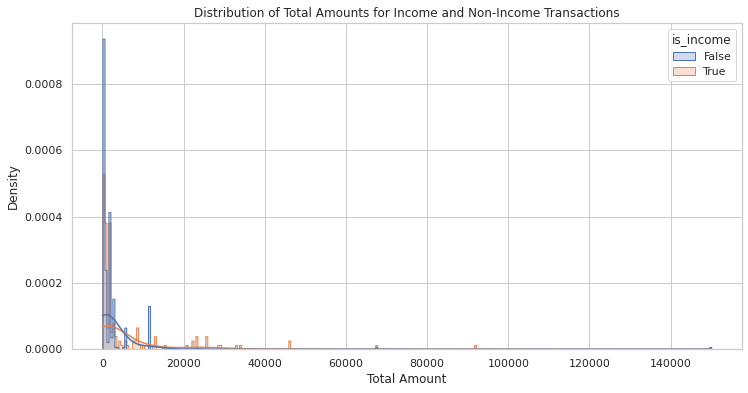

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
#The Plot
plt.figure(figsize=(12, 6))
sns.histplot(payment_df, x='total', hue='is_income', element='step', stat='density', common_norm=False, kde=True)
plt.title('Distribution of Total Amounts for Income and Non-Income Transactions')
plt.xlabel('Total Amount')
plt.ylabel('Density')
plt.show()

The income transactions have a wider spread than the non-income. Most of the transactions in both categories have amounts concentrated in the lower range.

Checking the trend in payments over time

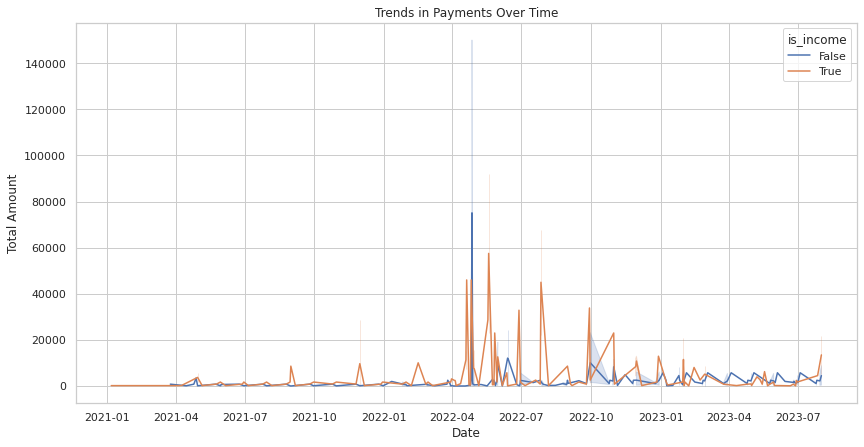

In [8]:
payment_df['date'] = pd.to_datetime(payment_df['date']).dt.date
plt.figure(figsize=(14, 7))
sns.lineplot(data=payment_df, x='date', y='total', hue='is_income')
plt.title('Trends in Payments Over Time')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.show()

Overview of contacts associated with transactions

In [9]:
contact_summary = payment_df.groupby('contact_id').agg(
    total_transactions=('id', 'count'),
    avg_total=('total', 'mean'),
    sum_total=('total', 'sum'),
    avg_exchange_rate=('exchange_rate', 'mean'),
    income_transactions=('is_income', 'sum')
).reset_index()

# Sorting the summary by 'sum_total' in descending order to see who has the highest total amount
contact_summary = contact_summary.sort_values(by='sum_total', ascending=False)
contact_summary.head(10)

,contact_id,total_transactions,avg_total,sum_total,avg_exchange_rate,income_transactions
8,31b86361-378a-47ef-9d43-25218e06ced3,11,24194.708182,266141.79,266.704545,11
28,d7d2b5fc-32e7-4011-94a4-2c8aa0ff9e4f,36,7374.740278,265490.65,1.000000,36
15,763190a0-8e54-4082-ad28-4b25aaf3b31d,5,51100.000000,255500.00,1.000000,0
0,0c9af104-858d-44bc-aeba-ba3b4e6b9d5d,17,12176.470588,207000.00,1.000000,0
33,ffb145b0-8504-42da-b03d-4c4a573fd521,11,7854.272727,86397.00,1.000000,11
29,d9bcb374-807b-4b4c-a1da-742a152fe917,4,18744.687500,74978.75,1.000000,4
31,e2111283-b230-4bb7-8108-518ef4dfd9fa,8,8789.062500,70312.50,1.000000,8
22,a278f53a-57ab-4f50-8690-182a5c60d671,5,9654.200000,48271.00,1.000000,5
26,c7060a16-02ba-4029-ab85-4369caa9f18a,9,5143.055556,46287.50,1.000000,0
5,273eb8ed-cc9a-4f69-bc0b-fe80c1c37cd4,19,2387.210526,45357.00,1.000000,0


We can later map these contact id's to the contact details

Checking the the monthly income and expense trendline

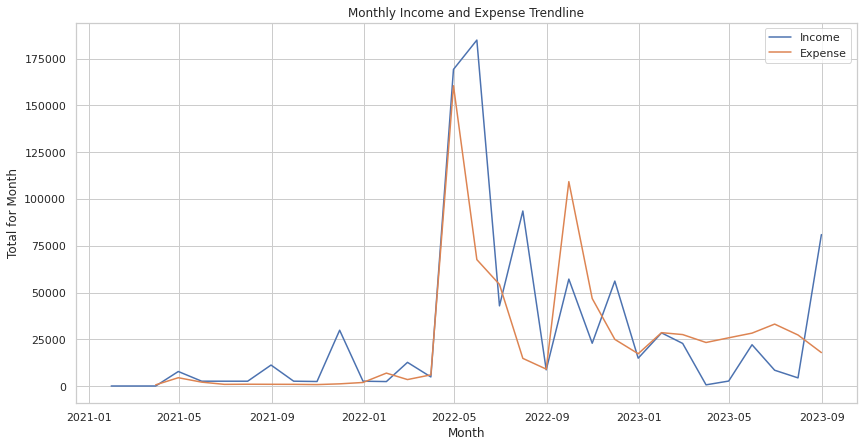

In [10]:
payment_df['date'] = pd.to_datetime(payment_df['date'])
income_data = payment_df[payment_df['is_income'] == True]
expense_data = payment_df[payment_df['is_income'] == False]

# Resampling the data by month and sum the total income for each month
monthly_income = income_data.resample('M', on='date').sum()['total'].reset_index()
monthly_expense = expense_data.resample('M', on='date').sum()['total'].reset_index()

# Plotting the monthly income trendline
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_income, x='date', y='total', label='Income')
sns.lineplot(data=monthly_expense, x='date', y='total', label='Expense')
plt.title('Monthly Income and Expense Trendline')
plt.xlabel('Month')
plt.ylabel('Total for Month')
plt.legend()
plt.show()

### Contacts

In [11]:
contacts_df.head()

,id,name,is_supplier,is_customer,email,phone
0,b422b740-54e0-405f-94fc-f5dd32b55e91,Frozen King,False,False,None,None
1,d7d2b5fc-32e7-4011-94a4-2c8aa0ff9e4f,Cindarella,False,True,None,None
2,e0857d09-69cc-4608-83b8-7e2083e678a3,Maleficent,True,True,None,None
3,8e81fbc4-4f33-4ae9-bf5e-a2415372e77b,Snow White,False,True,None,None
4,94589e82-ecdf-4c7b-9896-f5e54b8d95af,Ariel new,False,True,ariel@mail.com,None


Distribution of contacts based on whether they are a customer or supplier

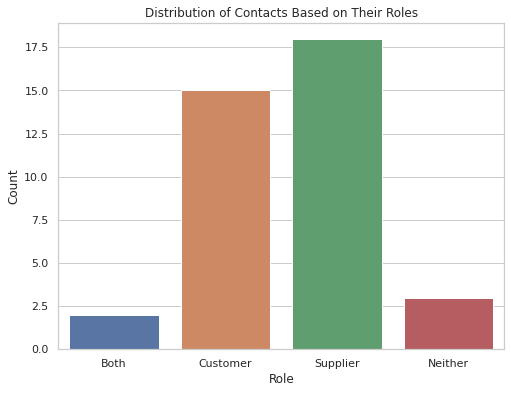

In [12]:
import numpy as np

# Define a new column 'role' to categorize contacts based on their roles
conditions = [
    (contacts_df['is_supplier'] & contacts_df['is_customer']),
    (~contacts_df['is_supplier'] & contacts_df['is_customer']),
    (contacts_df['is_supplier'] & ~contacts_df['is_customer']),
    (~contacts_df['is_supplier'] & ~contacts_df['is_customer'])
]
choices = ['Both', 'Customer', 'Supplier', 'Neither']
contacts_df['role'] = np.select(conditions, choices)

# Plot the distribution of roles
plt.figure(figsize=(8, 6))
sns.countplot(data=contacts_df, x='role', order=choices)
plt.title('Distribution of Contacts Based on Their Roles')
plt.xlabel('Role')
plt.ylabel('Count')
plt.show()

Checking how many contacts have emails

In [13]:
contacts_df.dropna(subset=['email']).shape[0]

6

### Items

In [14]:
item_df

,id,name,code,quantity_on_hand,purchase_unit_price,sale_unit_price
0,fd4873eb-1b87-4bc5-ba82-de91a556b70b,Frozen cupcakes,FR001,619,1,45
1,8d4fc345-c882-4bb1-b0ea-017fccdedd66,Cinderella Cupcakes,CIN001,0,1,15
2,1355f97e-5572-408d-bb82-fdf9f72b370c,Tinkerbel cake,TIN001,14,15,125
3,817308ce-21e8-4a6c-a2e3-b13100823845,Zoo Chocolates,CHO001,7,150,200
4,8e20b962-6390-425f-9ae8-7d28d54d4c09,Ariel Cupcakes,ARI001,475,3,50
5,295f1964-2b0a-42f4-ad24-aad148482afa,Jasmine Cake,JAS001,100,10,0


Calculating the potential turnover for each item

In [15]:
item_df['profit_per_item'] = item_df['sale_unit_price'] - item_df['purchase_unit_price']
item_df['potential_turnover'] = item_df['profit_per_item'] * item_df['quantity_on_hand']
item_df

,id,name,code,quantity_on_hand,purchase_unit_price,sale_unit_price,profit_per_item,potential_turnover
0,fd4873eb-1b87-4bc5-ba82-de91a556b70b,Frozen cupcakes,FR001,619,1,45,44,27236
1,8d4fc345-c882-4bb1-b0ea-017fccdedd66,Cinderella Cupcakes,CIN001,0,1,15,14,0
2,1355f97e-5572-408d-bb82-fdf9f72b370c,Tinkerbel cake,TIN001,14,15,125,110,1540
3,817308ce-21e8-4a6c-a2e3-b13100823845,Zoo Chocolates,CHO001,7,150,200,50,350
4,8e20b962-6390-425f-9ae8-7d28d54d4c09,Ariel Cupcakes,ARI001,475,3,50,47,22325
5,295f1964-2b0a-42f4-ad24-aad148482afa,Jasmine Cake,JAS001,100,10,0,-10,-1000


profit per item

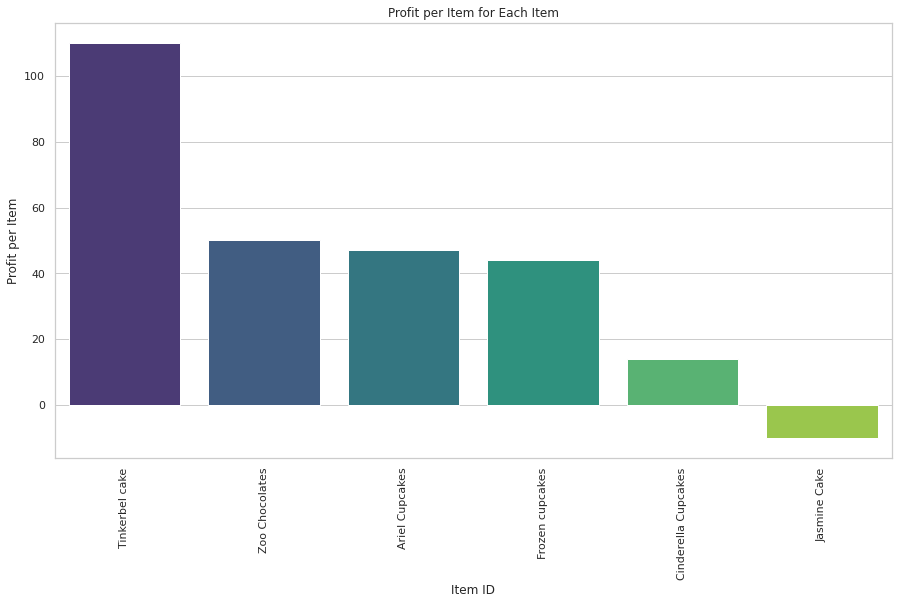

In [16]:
# Create a bar graph for Profit per Item
plt.figure(figsize=(15, 8))

# Sort the items by profit per item for better visualization
sorted_items_df = item_df.sort_values(by='profit_per_item', ascending=False)

# Create the bar graph
sns.barplot(data=sorted_items_df, x='name', y='profit_per_item', palette='viridis')

# Add labels and title
plt.xlabel('Item ID')
plt.ylabel('Profit per Item')
plt.title('Profit per Item for Each Item')

# Rotate x-labels for better visibility
plt.xticks(rotation=90)

# Show the plot
plt.show()


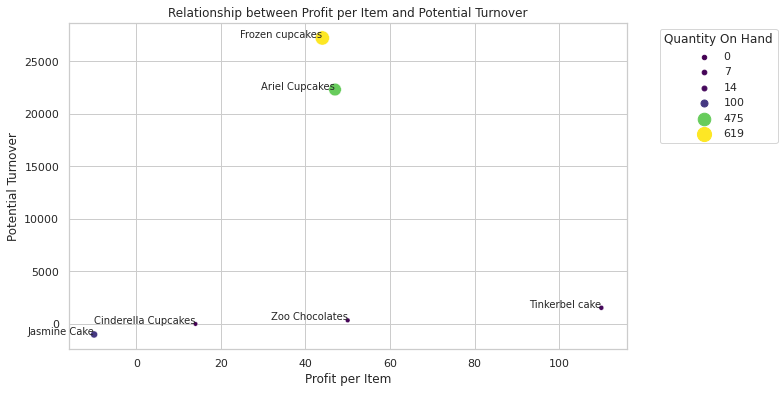

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=item_df, x='profit_per_item', y='potential_turnover', hue='quantity_on_hand', palette='viridis', size='quantity_on_hand', sizes=(20, 200))
plt.title('Relationship between Profit per Item and Potential Turnover')
for idx, row in item_df.iterrows():
    plt.text(row['profit_per_item'], row['potential_turnover'], row['name'], fontsize=10, ha='right')
plt.xlabel('Profit per Item')
plt.ylabel('Potential Turnover')
plt.legend(title='Quantity On Hand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

- Items that have both high "Profit per Item" and high "Potential Turnover" are the high-leverage items for the business. These are the items you'd want to focus on for sales promotions, as they have the most revenue-generating potential.
- Items with low "Profit per Item" but high "Potential Turnover" might indicate that there's a significant quantity of low-margin stock. This could be a concern for inventory holding costs and may require sales promotions to clear stock.
- Items with high "Potential Turnover" but low stock levels ("Quantity On Hand") may need to be replenished soon to capitalize on potential sales.Hence a profit/turnover index would help

### Invoice

In [18]:
invoice_df.head()

,id,issue_date,due_date,paid_date,paid,contact_id,total,amount_due,exchange_rate,currency,is_sale
0,90381d5a-9348-4208-915c-60b082378370,2021-01-31T00:00:00.000Z,2021-02-06T00:00:00.000Z,2021-02-06T00:00:00.000Z,True,8e81fbc4-4f33-4ae9-bf5e-a2415372e77b,174.800000,0.0,1.0000,GBP,True
1,e4f53ac4-3aa8-4332-9082-c6551e09d90b,2021-02-23T00:00:00.000Z,2021-02-28T00:00:00.000Z,None,False,e0857d09-69cc-4608-83b8-7e2083e678a3,10000.000000,0.0,1.0000,GBP,True
2,3dec381c-7af5-436d-8b35-2d3a69b95f89,2021-02-28T00:00:00.000Z,2021-03-06T00:00:00.000Z,2021-03-06T00:00:00.000Z,True,8e81fbc4-4f33-4ae9-bf5e-a2415372e77b,174.800000,0.0,1.0000,GBP,True
3,aca26d49-abcb-4320-ac50-e0e613e34393,2021-03-07T00:00:00.000Z,2021-03-25T00:00:00.000Z,2022-04-05T00:00:00.000Z,True,cf2b417f-352e-486f-a5e0-a32cbbfa0826,848.346016,0.0,1.9317,NZD,True
4,d1c5eee6-9b87-46ed-a153-0a344f242675,2021-03-14T00:00:00.000Z,2021-04-30T00:00:00.000Z,2021-04-30T00:00:00.000Z,True,d7d2b5fc-32e7-4011-94a4-2c8aa0ff9e4f,1725.000000,0.0,1.0000,GBP,True


Total Invoice Amount Over Time

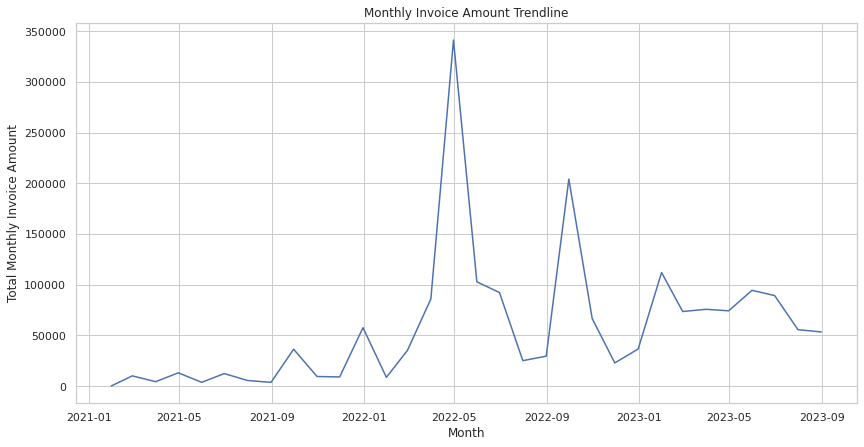

In [19]:
# Convert 'issue_date' to datetime format for resampling
invoice_df['issue_date'] = pd.to_datetime(invoice_df['issue_date'])

# Resample the data by month and sum the total invoice amount for each month
monthly_invoice_total = invoice_df.resample('M', on='issue_date').sum()['total'].reset_index()

# Plot the monthly invoice amount trendline
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_invoice_total, x='issue_date', y='total')
plt.title('Monthly Invoice Amount Trendline')
plt.xlabel('Month')
plt.ylabel('Total Monthly Invoice Amount')
plt.show()

Distributions of different invoice amounts in different currencies

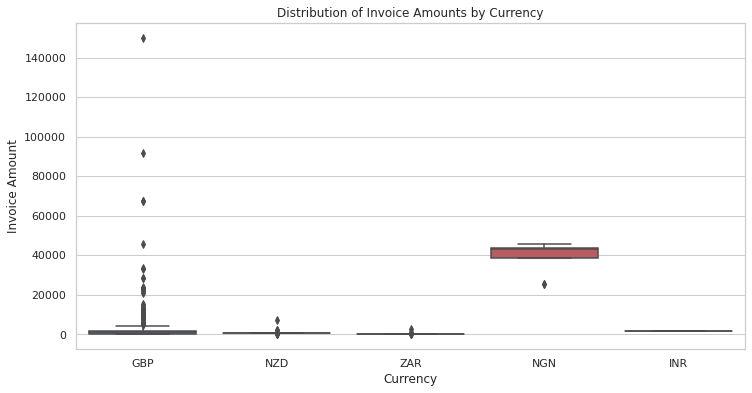

In [20]:
# Plot the distribution of invoice amounts by currency
plt.figure(figsize=(12, 6))
sns.boxplot(data=invoice_df, x='currency', y='total')
plt.title('Distribution of Invoice Amounts by Currency')
plt.xlabel('Currency')
plt.ylabel('Invoice Amount')
plt.show()


In [21]:
print("Total amount of unpaid payments: ",invoice_df[invoice_df['paid'] == False]['total'].sum())

Total amount of unpaid payments:  247075.1717803331


Investigating late payments

In [22]:
invoice_df.head()

,id,issue_date,due_date,paid_date,paid,contact_id,total,amount_due,exchange_rate,currency,is_sale
0,90381d5a-9348-4208-915c-60b082378370,2021-01-31 00:00:00+00:00,2021-02-06T00:00:00.000Z,2021-02-06T00:00:00.000Z,True,8e81fbc4-4f33-4ae9-bf5e-a2415372e77b,174.800000,0.0,1.0000,GBP,True
1,e4f53ac4-3aa8-4332-9082-c6551e09d90b,2021-02-23 00:00:00+00:00,2021-02-28T00:00:00.000Z,None,False,e0857d09-69cc-4608-83b8-7e2083e678a3,10000.000000,0.0,1.0000,GBP,True
2,3dec381c-7af5-436d-8b35-2d3a69b95f89,2021-02-28 00:00:00+00:00,2021-03-06T00:00:00.000Z,2021-03-06T00:00:00.000Z,True,8e81fbc4-4f33-4ae9-bf5e-a2415372e77b,174.800000,0.0,1.0000,GBP,True
3,aca26d49-abcb-4320-ac50-e0e613e34393,2021-03-07 00:00:00+00:00,2021-03-25T00:00:00.000Z,2022-04-05T00:00:00.000Z,True,cf2b417f-352e-486f-a5e0-a32cbbfa0826,848.346016,0.0,1.9317,NZD,True
4,d1c5eee6-9b87-46ed-a153-0a344f242675,2021-03-14 00:00:00+00:00,2021-04-30T00:00:00.000Z,2021-04-30T00:00:00.000Z,True,d7d2b5fc-32e7-4011-94a4-2c8aa0ff9e4f,1725.000000,0.0,1.0000,GBP,True


In [23]:
invoice_df['days_late'] = (pd.to_datetime(invoice_df['paid_date']) - pd.to_datetime(invoice_df['due_date'])).dt.days

# Filter tdata for only late payments
invoice_df['late_payment'] = invoice_df['paid_date'] > invoice_df['due_date']
late_payments_df = invoice_df[invoice_df['late_payment']]

# Calculate the metrics by contact
average_days_late_per_contact = late_payments_df.groupby('contact_id')['days_late'].mean().reset_index()
count_late_payments_per_contact = late_payments_df.groupby('contact_id')['days_late'].count().reset_index()
sum_late_payments_per_contact = late_payments_df.groupby('contact_id')['total'].sum().reset_index()

# Renaming cols
sum_late_payments_per_contact.rename(columns={'total': 'sum_late_payments'}, inplace=True)
count_late_payments_per_contact.rename(columns={'days_late': 'late_payments_count'}, inplace=True)

# Merge the average days late, count of late payments, and sum of late payments for each contact_id
late_payments_summary_df = pd.merge(average_days_late_per_contact, count_late_payments_per_contact, on='contact_id')
late_payments_summary_df = pd.merge(late_payments_summary_df, sum_late_payments_per_contact, on='contact_id')

late_payments_summary_df.sort_values(by='sum_late_payments', ascending=False, inplace=True)
late_payments_summary_df.head()

,contact_id,days_late,late_payments_count,sum_late_payments
6,31b86361-378a-47ef-9d43-25218e06ced3,38.40,5,147020.978738
21,d7d2b5fc-32e7-4011-94a4-2c8aa0ff9e4f,41.50,8,91147.500000
25,ffb145b0-8504-42da-b03d-4c4a573fd521,28.75,4,49687.500000
23,e2111283-b230-4bb7-8108-518ef4dfd9fa,15.00,2,35925.000000
17,a9797cb2-4805-4528-bbcb-fdb94368bee6,32.00,3,31454.428100
